# bindsnet安装

In [1]:
# !nvidia-smi
!pip install bindsnet
import torch
print(torch.__version__)

......
1.6.0+cu101


# 定义网络

In [2]:
import os
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import transforms
from tqdm import tqdm

from time import time as t

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.models import DiehlAndCook2015
from bindsnet.network.monitors import Monitor
from bindsnet.utils import get_square_weights, get_square_assignments
from bindsnet.evaluation import all_activity, proportion_weighting, assign_labels
from bindsnet.analysis.plotting import (
    plot_input,
    plot_spikes,
    plot_weights,
    plot_assignments,
    plot_performance,
    plot_voltages,
)


parser = argparse.ArgumentParser()
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--n_neurons", type=int, default=100)
parser.add_argument("--n_epochs", type=int, default=1)
parser.add_argument("--n_test", type=int, default=10000)
parser.add_argument("--n_workers", type=int, default=2)
parser.add_argument("--exc", type=float, default=22.5)
parser.add_argument("--inh", type=float, default=120)
parser.add_argument("--theta_plus", type=float, default=0.05)
parser.add_argument("--time", type=int, default=120)
parser.add_argument("--dt", type=int, default=1.0)
parser.add_argument("--intensity", type=float, default=64)
parser.add_argument("--progress_interval", type=int, default=10)
parser.add_argument("--update_interval", type=int, default=250)
parser.add_argument("--train", dest="train", action="store_true")
parser.add_argument("--test", dest="train", action="store_false")
parser.add_argument("--plot", dest="plot", action="store_true")
parser.add_argument("--gpu", dest="gpu", action="store_true")
parser.add_argument("--checkpoint", dest="checkpoint", action="store_true")
parser.add_argument("--local", dest="local", action="store_true")
parser.set_defaults(plot=False, gpu=False, train=True, checkpoint=False, local=False)

# args = parser.parse_args()
args = parser.parse_args(args=[])

seed = args.seed
n_neurons = args.n_neurons
n_neurons = 100
n_epochs = args.n_epochs
n_test = args.n_test
n_workers = args.n_workers
n_workers = 2
exc = args.exc
inh = args.inh
theta_plus = args.theta_plus
time = args.time
dt = args.dt
intensity = args.intensity
if intensity > time:
    raise Exception("time must greater than intensity")
progress_interval = args.progress_interval
update_interval = args.update_interval
update_interval = 300
train = args.train
plot = args.plot
gpu = args.gpu
checkpoint = args.checkpoint
local = args.local

# Sets up Gpu use
if gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    if gpu:
        gpu = False

# Determines number of workers to use
if n_workers == -1:
    n_workers = gpu * 4 * torch.cuda.device_count()

if not train:
    update_interval = n_test

n_sqrt = int(np.ceil(np.sqrt(n_neurons)))
start_intensity = intensity

weight_dirc_path = "weights/" if local else "drive/My Drive/SNN/"
weight_name = "SNN_withou_batch"

# Build network.
network = DiehlAndCook2015(
    n_inpt=784,
    n_neurons=n_neurons,
    exc=exc,
    inh=inh,
    dt=dt,
    norm=78.4,
    theta_plus=theta_plus,
    inpt_shape=(1, 28, 28),
)

# Directs network to GPU
if gpu:
    network.to("cuda")

# Load MNIST data.
train_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    # root=os.path.join("..", "..", "data", "MNIST"),
    root="data" if local else os.path.join("..", "..", "data", "MNIST"),
    download=True,
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

# Record spikes during the simulation.
spike_record = torch.zeros(update_interval, time, n_neurons)

# Neuron assignments and spike proportions.
n_classes = 10
assignments = -torch.ones(n_neurons)
proportions = torch.zeros(n_neurons, n_classes)
rates = torch.zeros(n_neurons, n_classes)

if checkpoint:
  weights = torch.load(weight_dirc_path + weight_name + ".pth")
  network.load_state_dict(weights)
#   assignments = weights["assignments"]
#   proportions = weights["proportions"]
#   rates = weights["rates"]


# Sequence of accuracy estimates.
accuracy = {"all": [], "proportion": []}

# Voltage recording for excitatory and inhibitory layers.
exc_voltage_monitor = Monitor(network.layers["Ae"], ["v"], time=time)
inh_voltage_monitor = Monitor(network.layers["Ai"], ["v"], time=time)
network.add_monitor(exc_voltage_monitor, name="exc_voltage")
network.add_monitor(inh_voltage_monitor, name="inh_voltage")

# Set up monitors for spikes and voltages
spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=time)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

voltages = {}
for layer in set(network.layers) - {"X"}:
    voltages[layer] = Monitor(network.layers[layer], state_vars=["v"], time=time)
    network.add_monitor(voltages[layer], name="%s_voltages" % layer)

inpt_ims, inpt_axes = None, None
spike_ims, spike_axes = None, None
weights_im = None
assigns_im = None
perf_ax = None
voltage_axes, voltage_ims = None, None

Extracting ../../data/MNIST/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/TorchvisionDatasetWrapper/raw



Extracting ../../data/MNIST/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/TorchvisionDatasetWrapper/raw


Extracting ../../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/TorchvisionDatasetWrapper/raw


Extracting ../../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/TorchvisionDatasetWrapper/raw
Processing...
Done!


# 训练网络

  0%|          | 0/60000 [00:00<?, ?it/s]




Progress: 0 / 1 (0.0007 seconds)


  0%|          | 300/60000 [01:16<4:13:56,  3.92it/s]

All activity accuracy: 8.67 (last), 8.67 (average), 8.67 (best)
Proportion weighting accuracy: 8.67 (last), 8.67 (average), 8.67 (best)
......


100%|█████████▉| 59700/60000 [4:47:55<01:25,  3.49it/s]

All activity accuracy: 82.33 (last), 76.27 (average), 87.67 (best)
Proportion weighting accuracy: 83.33 (last), 77.11 (average), 88.33 (best)


100%|██████████| 60000/60000 [4:49:20<00:00,  3.46it/s]


Progress: 1 / 1 (17360.6965 seconds)
Training complete.


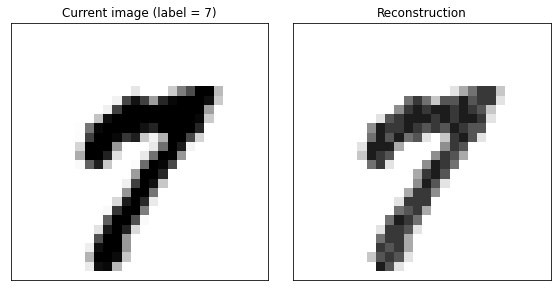

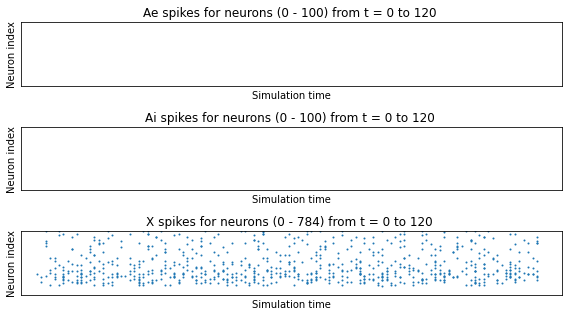

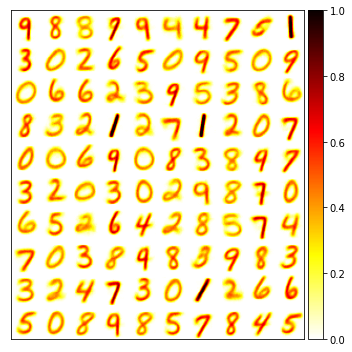

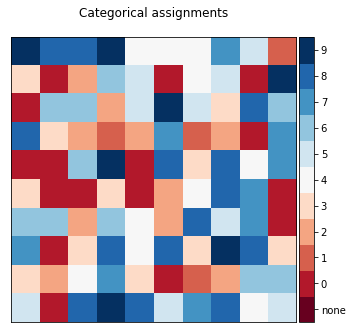

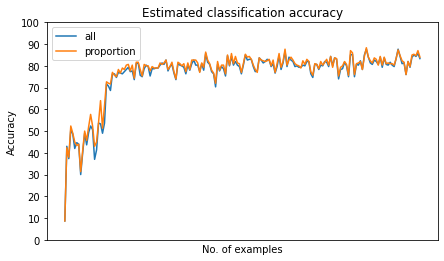

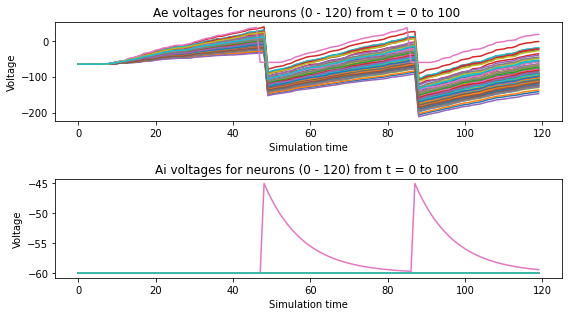

In [3]:
# from IPython import display
# Train the network.
# print("Begin training.")
start = t()
labels = []
label_list = list(range(10))
for epoch in range(n_epochs):

    if epoch % progress_interval == 0:
        print("Progress: %d / %d (%.4f seconds)" % (epoch, n_epochs, t() - start))
        start = t()

    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=n_workers, pin_memory=gpu
    )

    for step, batch in enumerate(tqdm(dataloader)):
        # Get next input sample.
        inputs = {"X": batch["encoded_image"].view(time, 1, 1, 28, 28)}
        if gpu:
            inputs = {k: v.cuda() for k, v in inputs.items()}

        if step % update_interval == 0 and step > 0:
            # Convert the array of labels into a tensor
            label_tensor = torch.tensor(labels)

            # Get network predictions.
            all_activity_pred = all_activity(
                spikes=spike_record, assignments=assignments, n_labels=n_classes
            )
            proportion_pred = proportion_weighting(
                spikes=spike_record,
                assignments=assignments,
                proportions=proportions,
                n_labels=n_classes,
            )

            # Compute network accuracy according to available classification strategies.
            accuracy["all"].append(
                100
                * torch.sum(label_tensor.long() == all_activity_pred).item()
                / len(label_tensor)
            )
            accuracy["proportion"].append(
                100
                * torch.sum(label_tensor.long() == proportion_pred).item()
                / len(label_tensor)
            )

            print(
                "All activity accuracy: %.2f (last), %.2f (average), %.2f (best)"
                % (
                    accuracy["all"][-1],
                    np.mean(accuracy["all"]),
                    np.max(accuracy["all"]),
                )
            )
            print(
                "Proportion weighting accuracy: %.2f (last), %.2f (average), %.2f (best)"
                % (
                    accuracy["proportion"][-1],
                    np.mean(accuracy["proportion"]),
                    np.max(accuracy["proportion"]),
                )
            )

            # Assign labels to excitatory layer neurons.
            assignments, proportions, rates = assign_labels(
                spikes=spike_record,
                labels=label_tensor,
                n_labels=n_classes,
                # rates=rates, # by lwk
            )

            labels = []

        labels.append(batch["label"])

        # Run the network on the input.
        network.run(inputs=inputs, time=time, input_time_dim=1)

        # Get voltage recording.
        exc_voltages = exc_voltage_monitor.get("v")
        inh_voltages = inh_voltage_monitor.get("v")

        # Add to spikes recording.
        spike_record[step % update_interval] = spikes["Ae"].get("s").squeeze()

        # Optionally plot various simulation information.
        if step % 6000 == 0 and step > 0:
            plot = True
        else:
            plot = False
        if plot:
            # display.clear_output(wait=True)
            image = batch["image"].view(28, 28)
            inpt = inputs["X"].view(time, 784).sum(0).view(28, 28)
            input_exc_weights = network.connections[("X", "Ae")].w
            square_weights = get_square_weights(
                input_exc_weights.view(784, n_neurons), n_sqrt, 28
            )
            square_assignments = get_square_assignments(assignments, n_sqrt)
            spikes_ = {layer: spikes[layer].get("s") for layer in spikes}
            voltages = {"Ae": exc_voltages, "Ai": inh_voltages}
            inpt_axes, inpt_ims = plot_input(
                image, inpt, label=batch["label"], axes=inpt_axes, ims=inpt_ims
            )
            spike_ims, spike_axes = plot_spikes(spikes_, ims=spike_ims, axes=spike_axes)
            weights_im = plot_weights(square_weights, im=weights_im)
            assigns_im = plot_assignments(square_assignments, im=assigns_im, classes=label_list)
            perf_ax = plot_performance(accuracy, ax=perf_ax)
            voltage_ims, voltage_axes = plot_voltages(
                voltages, ims=voltage_ims, axes=voltage_axes, plot_type="line"
            )

            # plt.pause(1e-8)
            # plt.pause(0.1)

        # Reset all layer except connections
        network.reset_state_variables()  # Reset state variables.

print("Progress: %d / %d (%.4f seconds)" % (epoch + 1, n_epochs, t() - start))
print("Training complete.")

# 测试网络

In [4]:
# Load MNIST data.
test_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root="data" if local else os.path.join("..", "..", "data", "MNIST"),
    download=False,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

# Sequence of accuracy estimates.
accuracy = {"all": 0, "proportion": 0}

# Record spikes during the simulation.
spike_record = torch.zeros(1, int(time/dt), n_neurons)

# Train the network.
print("Begin testing")
network.train(mode=False)
start = t()

for step, batch in enumerate(tqdm(test_dataset)):
    # Get next input sample.
    inputs = {"X": batch["encoded_image"].view(int(time/dt), 1, 1, 28, 28)}
    if gpu:
        inputs = {k: v.cuda() for k, v in inputs.items()}

    # Run the network on the input.
    network.run(inputs=inputs, time=time, input_time_dim=1)

    # Add to spikes recording.
    spike_record[0] = spikes["Ae"].get("s").squeeze()

    # Convert the array of labels into a tensor
    label_tensor = torch.tensor(batch["label"])

    # Get network predictions.
    all_activity_pred = all_activity(
        spikes=spike_record, assignments=assignments, n_labels=n_classes
    )
    proportion_pred = proportion_weighting(
        spikes=spike_record,
        assignments=assignments,
        proportions=proportions,
        n_labels=n_classes,
    )

    # Compute network accuracy according to available classification strategies.
    accuracy["all"] += float(torch.sum(label_tensor.long() == all_activity_pred).item())
    accuracy["proportion"] += float(torch.sum(label_tensor.long() == proportion_pred).item())

    network.reset_state_variables()  # Reset state variables.

print("All activity accuracy: %.2f" % (accuracy["all"] / test_dataset.test_labels.shape[0]))
print("Proportion weighting accuracy: %.2f" % ( accuracy["proportion"] / test_dataset.test_labels.shape[0]))


print("Progress: %d / %d (%.4f seconds)" % (epoch + 1, n_epochs, t() - start))
print("Testing complete.")

  0%|          | 1/10000 [00:00<20:13,  8.24it/s]

Begin testing


100%|██████████| 10000/10000 [20:07<00:00,  8.28it/s]

All activity accuracy: 0.81
Proportion weighting accuracy: 0.82
Progress: 1 / 1 (1207.6580 seconds)
Testing complete.


# 保存网络到硬盘

In [5]:
# weights = {}
# weights["rates"] = rates
# torch.save(weights, weight_dirc_path + "rates.pth")
torch.save(network.state_dict(), weight_dirc_path + "_connections.pth")